# Basic Figures
Some figures for my talk at PyAstro 2018

In [50]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.net import Fido,attrs as a
from sunpy.time import TimeRange
import roman
import fiasco
import plasmapy.atomic

%matplotlib inline

## Sun Pictures
Download and plot some pretty pictures from AIA

In [11]:
q = Fido.search(
    a.Time(TimeRange('2011/02/12 15:30:00',10 * u.s)),
    a.Instrument('AIA'),
    a.Wavelength(90*u.angstrom,340*u.angstrom)
)

In [12]:
q

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2011-02-12 15:30:00,2011-02-12 15:30:01,SDO,AIA,FULLDISK,171.0 .. 171.0
2011-02-12 15:30:00,2011-02-12 15:30:01,SDO,AIA,FULLDISK,211.0 .. 211.0
2011-02-12 15:30:02,2011-02-12 15:30:03,SDO,AIA,FULLDISK,94.0 .. 94.0
2011-02-12 15:30:03,2011-02-12 15:30:04,SDO,AIA,FULLDISK,335.0 .. 335.0
2011-02-12 15:30:08,2011-02-12 15:30:09,SDO,AIA,FULLDISK,304.0 .. 304.0
2011-02-12 15:30:09,2011-02-12 15:30:10,SDO,AIA,FULLDISK,193.0 .. 193.0
2011-02-12 15:30:09,2011-02-12 15:30:10,SDO,AIA,FULLDISK,131.0 .. 131.0


In [13]:
res = Fido.fetch(q, wait=True, progress=True, path='data/{file}.fits')

[                                        ========================================


In [2]:
aia_files = [
    'data/aia_lev1_94a_2011_02_12t15_30_02_12z_image_lev1.fits.fits',
    'data/aia_lev1_131a_2011_02_12t15_30_09_62z_image_lev1.fits.fits',
    'data/aia_lev1_171a_2011_02_12t15_30_00_34z_image_lev1.fits.fits',
    'data/aia_lev1_193a_2011_02_12t15_30_09_41z_image_lev1.fits.fits',
    'data/aia_lev1_211a_2011_02_12t15_30_00_62z_image_lev1.fits.fits',
    'data/aia_lev1_335a_2011_02_12t15_30_03_63z_image_lev1.fits.fits'
]

In [3]:
corners = (u.Quantity((-400, -350),'arcsec'),u.Quantity((-200,-150),'arcsec'))

In [4]:
channel_labels = ['94', '131', '171', '193', '211', '335']

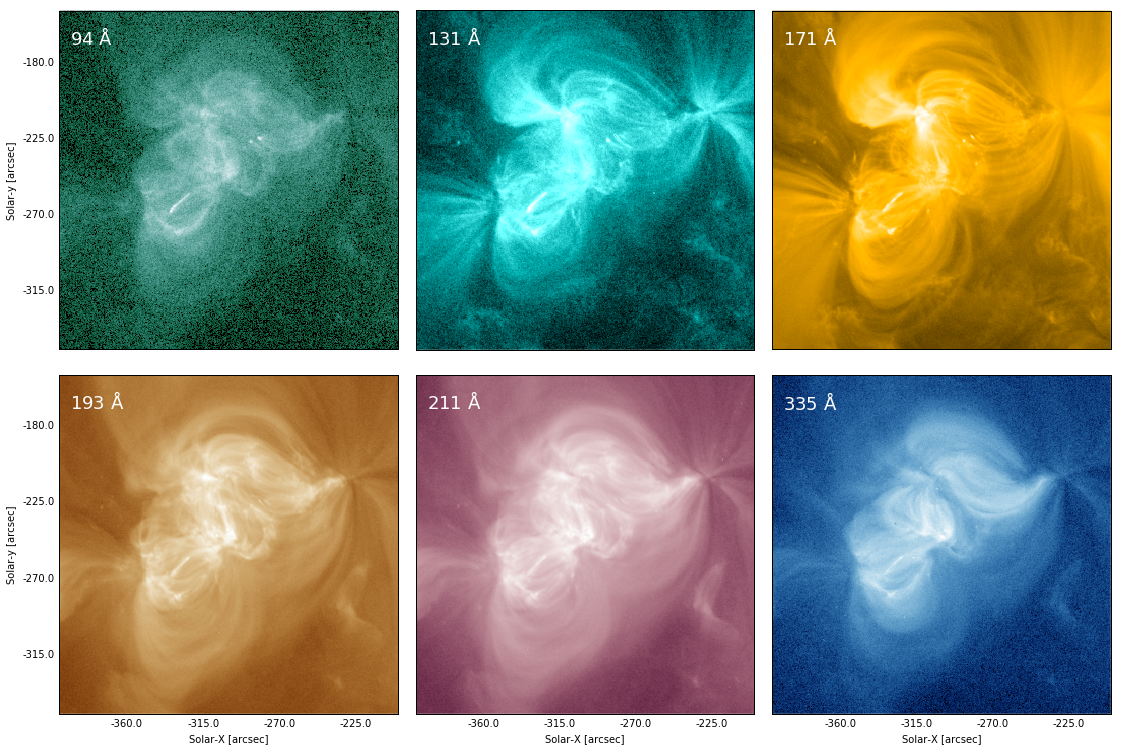

In [5]:
fig = plt.figure(figsize=(15,13.7/20*15))
for i,label in enumerate(channel_labels):
    m = sunpy.map.Map(aia_files[i])
    m = m.submap(SkyCoord(*corners[0], frame=m.coordinate_frame),
                 SkyCoord(*corners[1], frame=m.coordinate_frame))
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(annotate=False,title=False,axes=ax,vmin=0)
    ax.grid(alpha=0)
    lon=ax.coords[0]
    lat=ax.coords[1]
    if i%3 == 0:
        lat.set_axislabel('Solar-y [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i>2:
        lon.set_axislabel('Solar-X [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.text(10,300,f'{label} $\mathrm{{\AA}}$',color='w',fontsize=18);
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.tight_layout()
plt.savefig('../template/img/aia_ar.png',bbox_inches='tight')

## CHIANTI Periodic Table

In [86]:
tot_ions = 0
for el in fiasco.list_elements():
    for ion in fiasco.Element(el, [1e6]*u.K):
        tot_ions += 1

In [87]:
tot_ions

495

In [69]:
ion_list = []
for el_name in fiasco.list_elements():
    el = fiasco.Element(el_name,[1e6]*u.K)
    for ion in el:
        if ion._elvlc is None:
            continue
        ion_list.append({'Element': el.atomic_symbol, 'Stage': roman.toRoman(ion.ionization_stage),
                         'Levels': ion[-1].level,})

In [70]:
ion_table = pd.DataFrame(ion_list)
ion_table_pivot = ion_table.pivot('Element','Stage','Levels')
new_indices = sorted(ion_table_pivot.index, key=lambda x:plasmapy.atomic.atomic_number(x))
ion_table_pivot = ion_table_pivot.reindex(new_indices)
ion_table_pivot = ion_table_pivot.reindex_axis(sorted(ion_table_pivot.columns.tolist(),
                                                      key=lambda x:roman.fromRoman(x)),axis=1)

/Users/willbarnes/anaconda/envs/pyastro-2018-talk/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


/Users/willbarnes/anaconda/envs/pyastro-2018-talk/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


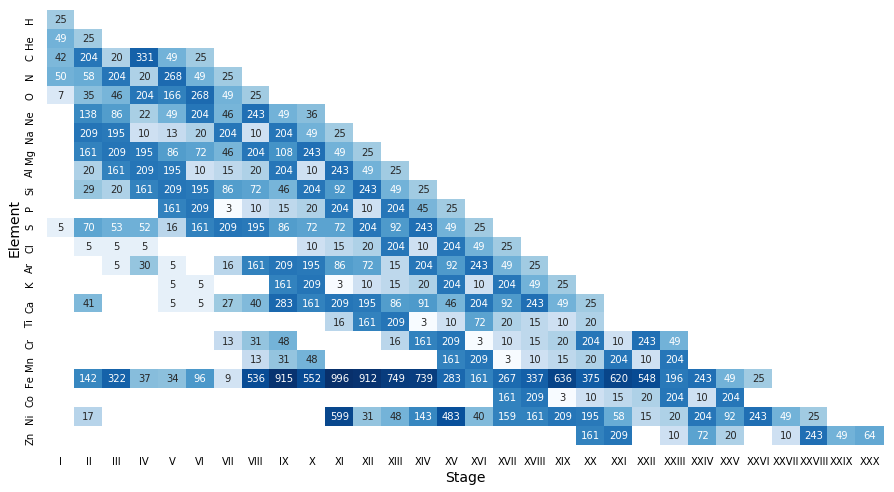

In [84]:
fig = plt.figure(figsize=(15,8))
ax=fig.gca()
my_cmap = plt.get_cmap('Blues')
my_cmap.set_bad(color='w')
sns.heatmap(ion_table_pivot,
            ax=ax,
            square=False,
            cmap=my_cmap,
            annot=True,
            fmt='.0f',
            norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e3),
            cbar_kws={'ticks':[1,10,100,1000]},
            cbar=False
           )
ax.tick_params(axis='both',which='both',bottom='off',left='off')
#plt.savefig('../template/img/chianti_periodictable.png', bbox_inches='tight')

## CHIANTI Derived Quantities

In [88]:
t = np.logspace(4,9,100)*u.K
ion = fiasco.Ion('Fe 16',t)

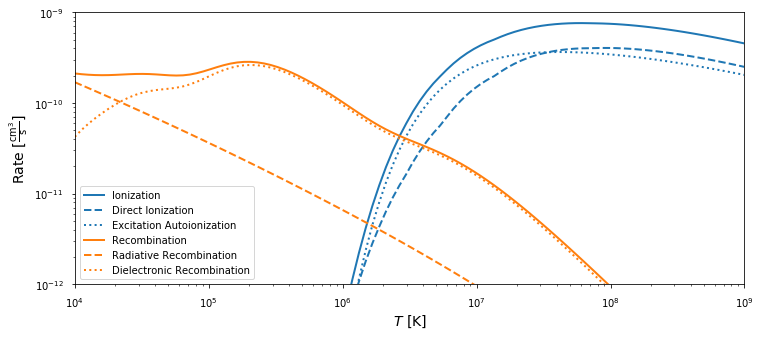

In [114]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
# Ionization Rate
i_rate = ion.ionization_rate()
ax.plot(t,i_rate,label='Ionization',color='C0',ls='-')
ax.plot(t,ion.direct_ionization_rate(),color='C0',ls='--',label='Direct Ionization')
ax.plot(t,ion.excitation_autoionization_rate(),color='C0',ls=':',label='Excitation Autoionization')
# Recombination rate
ax.plot(t,ion.recombination_rate(),label='Recombination',color='C1',ls='-')
ax.plot(t,ion.radiative_recombination_rate(),color='C1',ls='--',label='Radiative Recombination')
ax.plot(t,ion.dielectronic_recombination_rate(),color='C1',ls=':',label='Dielectronic Recombination')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-12,1e-9)
ax.set_xlim(1e4,1e9)
ax.set_xlabel(f'$T$ [{ion.temperature.unit.to_string("latex")}]')
ax.set_ylabel(f'Rate [{i_rate.unit.decompose().cgs.to_string("latex")}]')
ax.legend(loc=3)
fig.savefig('../template/img/rates.png',bbox_inches='tight')

## Element

In [121]:
el = fiasco.Element('iron',t)

In [123]:
ioneq = el.equilibrium_ionization()

In [124]:
ioneq.shape

(100, 27)

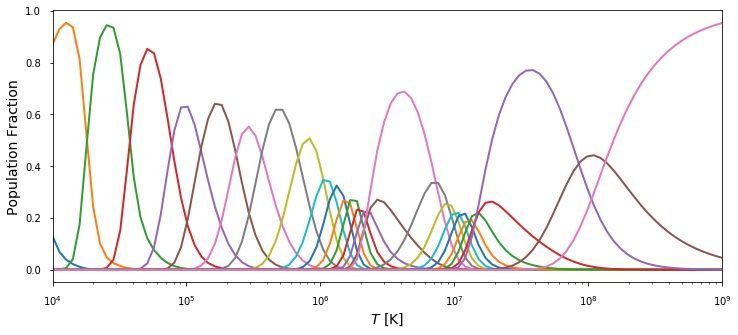

In [133]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
for ion in el:
    ax.plot(el.temperature, ioneq[:,ion.charge_state],color=f'C{ion.charge_state%10}')
ax.set_xscale('log')
ax.set_xlabel(f'$T$ [{el.temperature.unit.to_string("latex")}]')
ax.set_ylabel(r'Population Fraction')
ax.set_xlim(t[0].value,t[-1].value)
fig.savefig('../template/img/ioneq.png',bbox_inches='tight')

## Spectra

In [353]:
10.**np.array([6.1,6.75,7.25])*u.K

<Quantity [  1258925.41179417,  5623413.25190349, 17782794.10038923] K>

In [317]:
temperature = [10.**(6.1),10**(6.75),10.**(7.25)]*u.K
density = [1e10]/(u.cm**3)
em = [1e27]/(u.cm**5)

wvl_range = [186,197]*u.angstrom
bin_width = 0.01*u.angstrom

fe12 = fiasco.Ion('Fe 12', temperature)
fe24 = fiasco.Ion('Fe 24', temperature)
ca17 = fiasco.Ion('Ca 17', temperature)

### 1 ion

In [354]:
col = fiasco.IonCollection(fe24)

In [355]:
wvl,spec = col.spectrum(density,em,wavelength_range=wvl_range,bin_width=bin_width,)

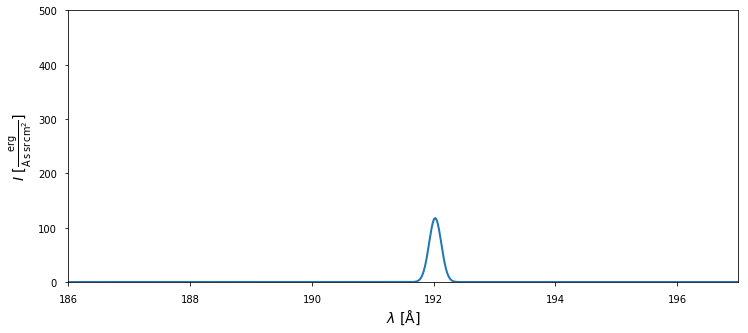

In [356]:
fig = plt.figure(figsize=(12,5));ax=fig.gca()
ax.plot(wvl,spec.sum(axis=(0,1)))
ax.set_ylim(0,500)
ax.set_xlim(*wvl_range.value)
ax.set_ylabel(f'$I$ [{spec.unit.to_string("latex")}]');
ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]');
fig.savefig('../template/img/spec_fe24.png',bbox_inches='tight')

### 2 ions

In [357]:
col = fe24 + ca17

In [358]:
wvl,spec = col.spectrum(density,em,wavelength_range=wvl_range,bin_width=bin_width,)

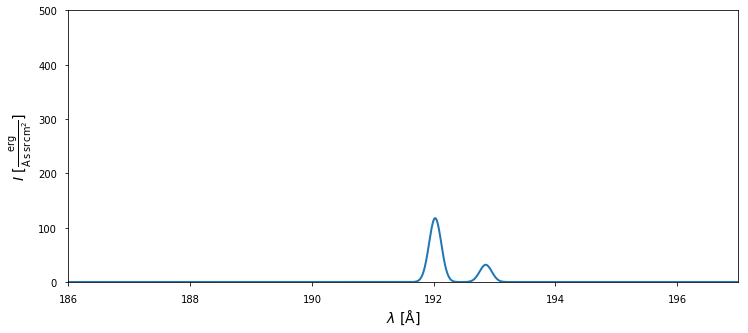

In [359]:
fig = plt.figure(figsize=(12,5));ax=fig.gca()
ax.plot(wvl,spec.sum(axis=(0,1)))
ax.set_ylim(0,500)
ax.set_xlim(*wvl_range.value)
ax.set_ylabel(f'$I$ [{spec.unit.to_string("latex")}]');
ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]');
fig.savefig('../template/img/spec_fe24_ca17.png',bbox_inches='tight')

### 3 ions

In [360]:
col = fe12 + fe24 + ca17

In [361]:
wvl,spec = col.spectrum(density,em,wavelength_range=wvl_range,bin_width=bin_width,)

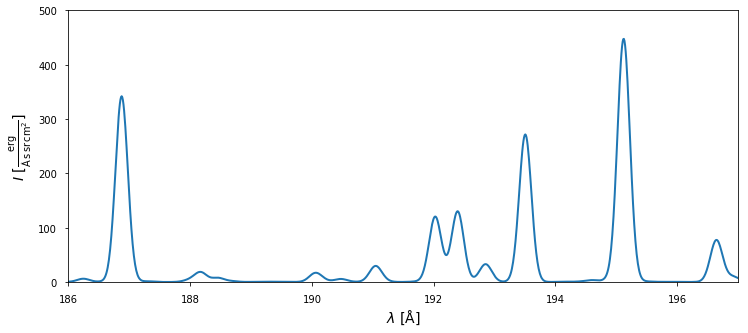

In [362]:
fig = plt.figure(figsize=(12,5));ax=fig.gca()
ax.plot(wvl,spec.sum(axis=(0,1)))
ax.set_ylim(0,500)
ax.set_xlim(*wvl_range.value)
ax.set_ylabel(f'$I$ [{spec.unit.to_string("latex")}]');
ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]');
fig.savefig('../template/img/spec_fe24_ca17_fe12.png',bbox_inches='tight')